In [59]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets.folder import DatasetFolder
import torchvision
from torchvision import transforms, datasets
from torchvision.io import read_image
from torchvision.models import resnet50, ResNet50_Weights, resnet18, ResNet18_Weights, swin_t, Swin_T_Weights
import sklearn
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
import os
from PIL import Image

# **RUN THIS ON CPU**

In [65]:
device = "cpu"
weights = ResNet50_Weights.IMAGENET1K_V1
model = resnet50(weights=weights)
model = model.to(device)
model.eval()

image_path = "/kaggle/input/dl-hw3/peppers-1-2.jpg"
tiger = '/kaggle/input/dl-hw3/panthera_tigris.jpeg'
indian_cobra = '/kaggle/input/dl-hw3/indian_cobra.jpeg'
hyena = '/kaggle/input/dl-hw3/hyena.jpeg'

image = Image.open(image_path)
img_tiger = Image.open(tiger)
img_cobra = Image.open(indian_cobra)
img_hyena = Image.open(hyena)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

image = transform(image).unsqueeze(0) # Add a batch dimension
img_tiger = transform(img_tiger).unsqueeze(0)
img_cobra = transform(img_cobra).unsqueeze(0)
img_hyena = transform(img_hyena).unsqueeze(0)

target_label_space_shuttle = 812
target_label_space_shuttle = torch.tensor([target_label_space_shuttle]).to(device)
target_label_brown_bear = torch.tensor([294]).to(device)
target_label_mongoose = torch.tensor([298]).to(device)
target_label_cheetah = torch.tensor([293]).to(device)

image_tensor = image.to(device)
img_tiger_tensor = img_tiger.to(device)
img_cobra_tensor = img_cobra.to(device)
img_hyena_tensor = img_hyena.to(device)

epsilon = 1e-2
alpha = 0.005
num_iter = 10
def create_adversarial_example(input_batch, y_fool, epsilon, alpha, num_iter, model):
    X = input_batch.clone().detach().requires_grad_(True)
    loss_fn = nn.CrossEntropyLoss()

    for i in range(num_iter):
        output = model(X)
        loss = -loss_fn(output, y_fool)  # Use negative sign for adversarial attack

        model.zero_grad()
        loss.backward()

        grad_sign = X.grad.data.sign()

        X.data = X.data + alpha * grad_sign
        X.data = torch.clamp(X.data, input_batch - epsilon, input_batch + epsilon)
        X.data = torch.clamp(X.data, 0, 1)

    return X

X_adv_pepper = create_adversarial_example(image_tensor, target_label_space_shuttle, epsilon, alpha, num_iter, model)
X_adv_tiger = create_adversarial_example(img_tiger_tensor, target_label_cheetah, epsilon, alpha, num_iter, model)
X_adv_indian_cobra = create_adversarial_example(img_cobra_tensor, target_label_mongoose, epsilon, alpha, num_iter, model)
X_adv_hyena = create_adversarial_example(img_hyena_tensor, target_label_brown_bear, epsilon, alpha, num_iter, model)

In [66]:
adversarial_pepper_image = X_adv_pepper.squeeze(0).detach().numpy().transpose(1,2,0)
adversarial_pepper_image.shape

(224, 224, 3)

In [67]:
adversarial_tiger_image = X_adv_tiger.squeeze(0).detach().numpy().transpose(1,2,0)
adversarial_tiger_image.shape

(224, 224, 3)

In [68]:
adversarial_cobra_image = X_adv_indian_cobra.squeeze(0).detach().numpy().transpose(1,2,0)
adversarial_cobra_image.shape

(224, 224, 3)

In [69]:
adversarial_hyena_image = X_adv_hyena.squeeze(0).detach().numpy().transpose(1,2,0)
adversarial_hyena_image.shape

(224, 224, 3)

In [70]:
img = image.squeeze(0).detach().numpy().transpose(1,2,0)
img.shape

(224, 224, 3)

In [71]:
image_tiger = img_tiger.squeeze(0).detach().numpy().transpose(1,2,0)
image_tiger.shape

(224, 224, 3)

In [72]:
image_cobra = img_cobra.squeeze(0).detach().numpy().transpose(1,2,0)
image_cobra.shape

(224, 224, 3)

In [73]:
image_hyena = img_hyena.squeeze(0).detach().numpy().transpose(1,2,0)
image_hyena.shape

(224, 224, 3)

In [74]:
def get_top_class_and_prob(X_adv):
    probabilities = torch.nn.functional.softmax(model(X_adv), dim=1)
    top_prob, top_class = torch.max(probabilities, 1)
    return top_class.item(), top_prob.item()

In [75]:
adversarial_label, adversarial_prob = get_top_class_and_prob(X_adv_pepper)
print(f'New class label after adversarial attack: {adversarial_label}')
print(f'Probability of misclassified label: {adversarial_prob}')
print(f'Adversarial Label for misclassified Pepper image is: {weights.meta["categories"][adversarial_label]}')

New class label after adversarial attack: 812
Probability of misclassified label: 0.9788151383399963
Adversarial Label for misclassified Pepper image is: space shuttle


In [76]:
adversarial_label_for_tiger, adversarial_prob_for_tiger = get_top_class_and_prob(X_adv_tiger)
print(f'New class label after adversarial attack for Tiger: {adversarial_label_for_tiger}')
print(f'Probability of misclassified label for Tiger: {adversarial_prob_for_tiger}')
print(f'Adversarial Label for misclassified Tiger image is: {weights.meta["categories"][adversarial_label_for_tiger]}')

New class label after adversarial attack for Tiger: 293
Probability of misclassified label for Tiger: 0.8388699293136597
Adversarial Label for misclassified Tiger image is: cheetah


In [77]:
adversarial_label_cobra, adversarial_prob_cobra = get_top_class_and_prob(X_adv_indian_cobra)
print(f'New class label after adversarial attack for Indian Cobra: {adversarial_label_cobra}')
print(f'Probability of misclassified label for Indian Cobra: {adversarial_prob_cobra}')
print(f'Adversarial Label for misclassified Cobra image is: {weights.meta["categories"][adversarial_label_cobra]}')

New class label after adversarial attack for Indian Cobra: 298
Probability of misclassified label for Indian Cobra: 0.9927330017089844
Adversarial Label for misclassified Cobra image is: mongoose


In [78]:
adversarial_label_hyena, adversarial_prob_hyena = get_top_class_and_prob(X_adv_hyena)
print(f'New class label after adversarial attack for Hyena: {adversarial_label_hyena}')
print(f'Probability of misclassified label for Hyena: {adversarial_prob_hyena}')
print(f'Adversarial Label for misclassified Hyena image is: {weights.meta["categories"][adversarial_label_hyena]}')

New class label after adversarial attack for Hyena: 294
Probability of misclassified label for Hyena: 0.956390917301178
Adversarial Label for misclassified Hyena image is: brown bear


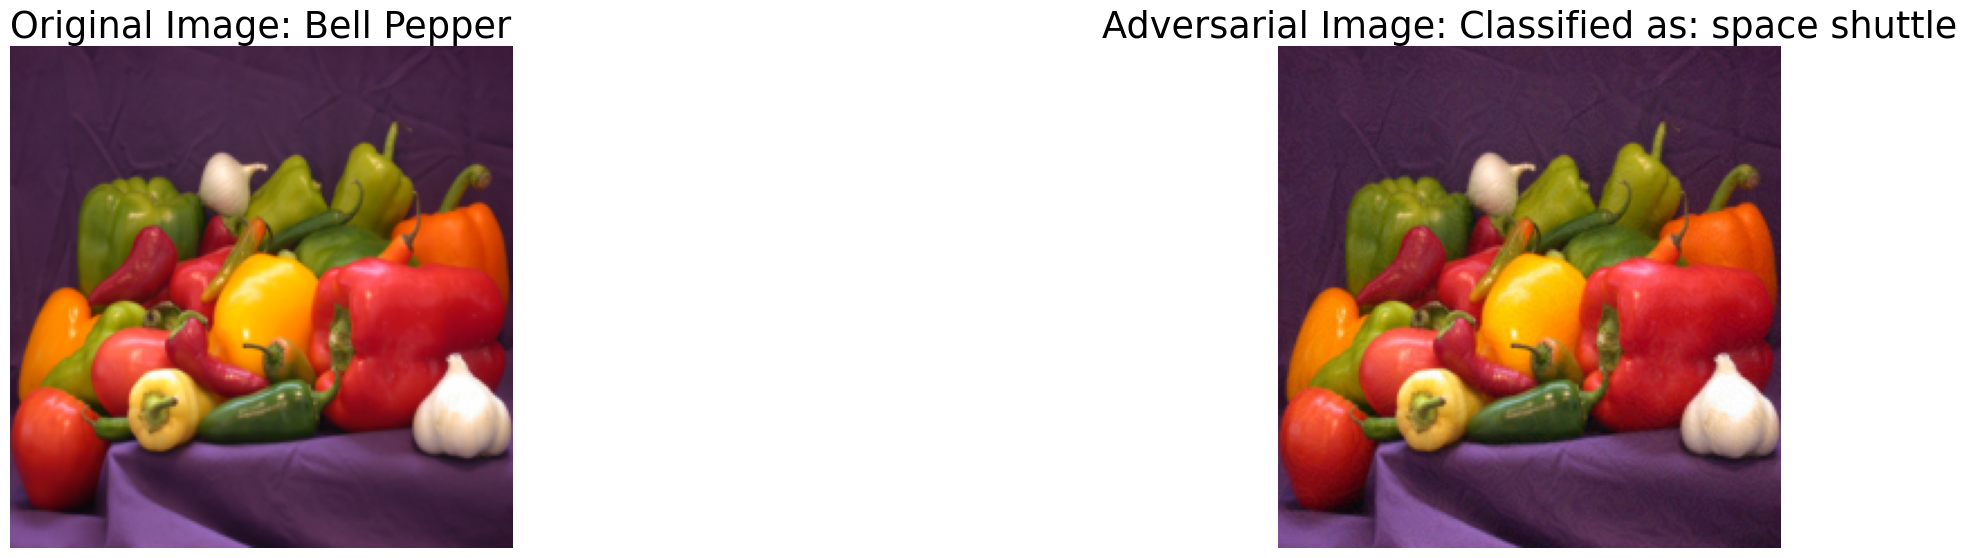

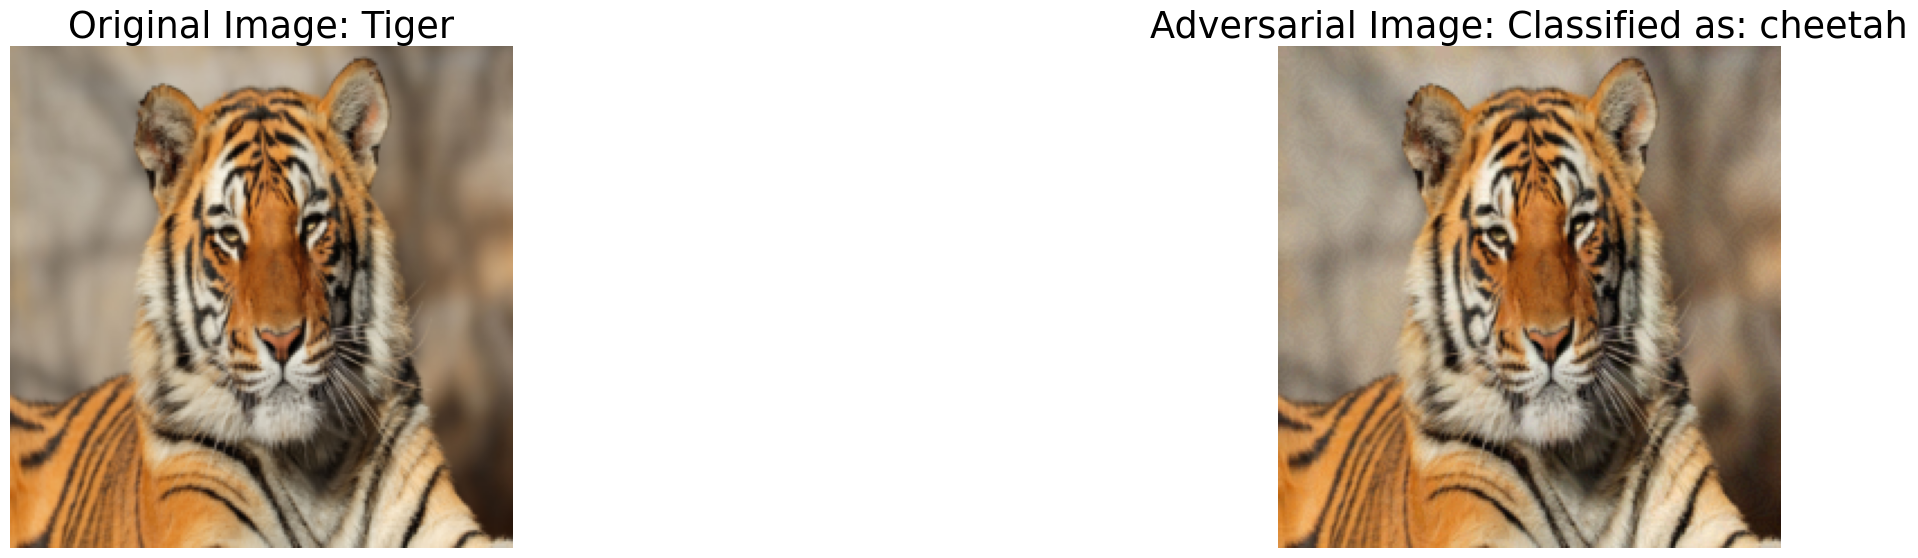

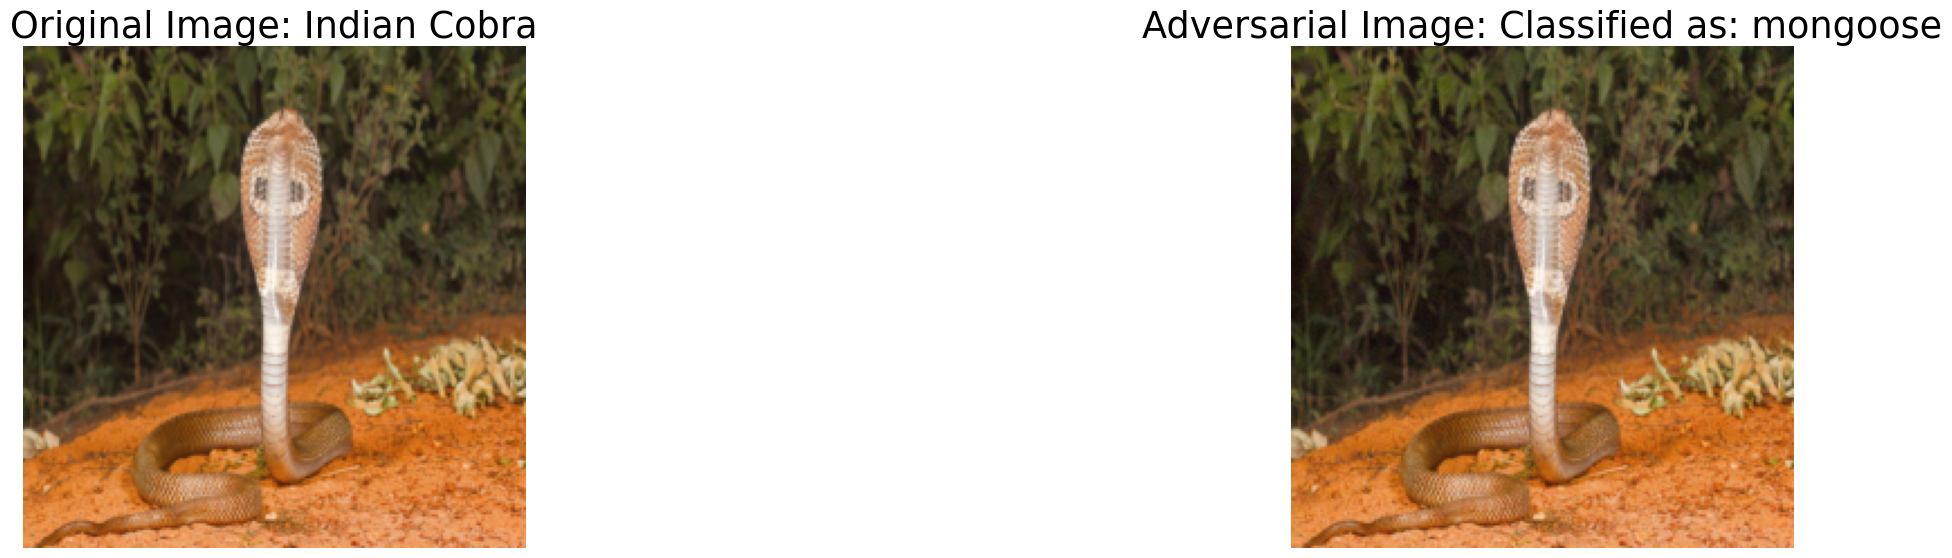

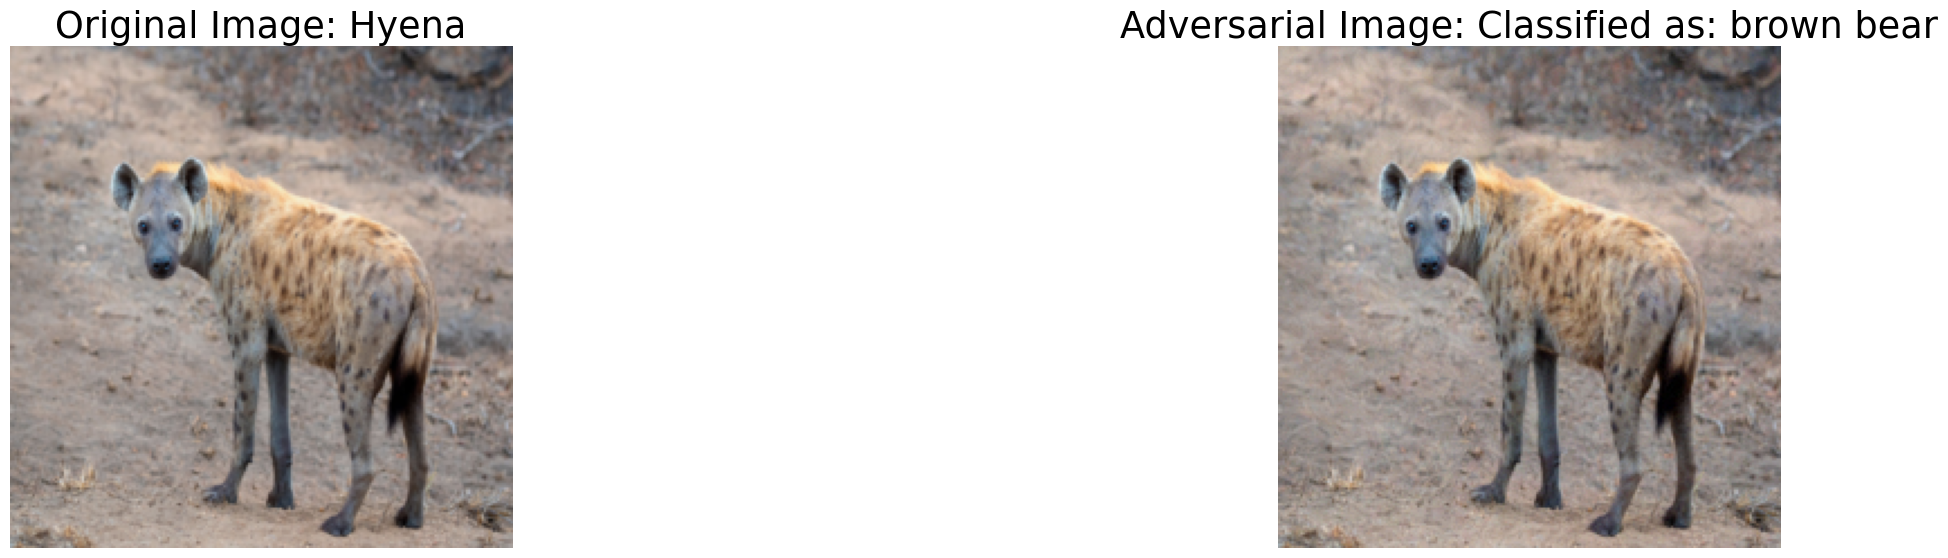

In [79]:
fig = plt.figure(figsize=(30,30))
plt.subplot(4,2,1)
plt.imshow(img)
plt.title('Original Image: Bell Pepper')
plt.axis('off')

plt.subplot(4,2,2)
plt.imshow(adversarial_pepper_image)
plt.title(f'Adversarial Image: Classified as: {weights.meta["categories"][adversarial_label]}')
plt.axis('off')
plt.show()

fig = plt.figure(figsize=(30,30))
plt.subplot(4,2,3)
plt.imshow(image_tiger)
plt.title('Original Image: Tiger')
plt.axis('off')

plt.subplot(4,2,4)
plt.imshow(adversarial_tiger_image)
plt.title(f'Adversarial Image: Classified as: {weights.meta["categories"][adversarial_label_for_tiger]}')
plt.axis('off')
plt.show()

fig = plt.figure(figsize=(30,30))
plt.subplot(4,2,3)
plt.imshow(image_cobra)
plt.title('Original Image: Indian Cobra')
plt.axis('off')

plt.subplot(4,2,4)
plt.imshow(adversarial_cobra_image)
plt.title(f'Adversarial Image: Classified as: {weights.meta["categories"][adversarial_label_cobra]}')
plt.axis('off')
plt.show()

fig = plt.figure(figsize=(30,30))
plt.subplot(4,2,3)
plt.imshow(image_hyena)
plt.title('Original Image: Hyena')
plt.axis('off')

plt.subplot(4,2,4)
plt.imshow(adversarial_hyena_image)
plt.title(f'Adversarial Image: Classified as: {weights.meta["categories"][adversarial_label_hyena]}')
plt.axis('off')
plt.show()

In [80]:
transform = transforms.Compose([transforms.RandomHorizontalFlip(p=1),
                                transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0), ratio=(1.0, 1.0)), 
                                transforms.Grayscale(num_output_channels=3),
                                ])
image_peppers_new_tf_tensor = transform(image)
image_peppers_new_tf_tensor = image_peppers_new_tf_tensor.to(device)
X_adv_new = create_adversarial_example(image_peppers_new_tf_tensor, target_label_space_shuttle, epsilon, alpha, num_iter, model)
class_label, prob = get_top_class_and_prob(X_adv_new)
print(f'New class label after transforms for Pepper: {weights.meta["categories"][class_label]}')
print(f'Probability of misclassified label: {prob}')

New class label after transforms for Pepper: space shuttle
Probability of misclassified label: 0.9985723495483398


In [81]:
image_tiger_new_tf = transform(img_tiger).to(device)
X_adv_new_tiger = create_adversarial_example(image_tiger_new_tf, target_label_cheetah, epsilon, alpha, num_iter, model)
class_label, prob = get_top_class_and_prob(X_adv_new_tiger)
print(f'New class label after transforms for Tiger: {weights.meta["categories"][class_label]}')
print(f'Probability of misclassified label: {prob}')

New class label after transforms for Tiger: cheetah
Probability of misclassified label: 0.8896711468696594


In [82]:
image_cobra_new_tf = transform(img_cobra).to(device)
X_adv_new_cobra = create_adversarial_example(image_cobra_new_tf, target_label_mongoose, epsilon, alpha, num_iter, model)
class_label, prob = get_top_class_and_prob(X_adv_new_cobra)
print(f'New class label after transforms for Indian Cobra: {weights.meta["categories"][class_label]}')
print(f'Probability of misclassified label: {prob}')

New class label after transforms for Indian Cobra: mongoose
Probability of misclassified label: 0.9942100048065186


In [83]:
image_hyena_new_tf = transform(img_hyena).to(device)
X_adv_new_hyena = create_adversarial_example(image_hyena_new_tf, target_label_brown_bear, epsilon, alpha, num_iter, model)
class_label, prob = get_top_class_and_prob(X_adv_new_hyena)
print(f'New class label after transforms for Hyena: {weights.meta["categories"][class_label]}')
print(f'Probability of misclassified label: {prob}')

New class label after transforms for Hyena: brown bear
Probability of misclassified label: 0.9754627346992493
